In [1]:
from corpus import Corpus
import numpy as np
import matplotlib.pyplot as plt

In [2]:
corpus = Corpus.from_file('data/train.json')

In [3]:
corpus.build_vectors()

In [4]:
corpus.build_np_vecs()

# new KNN

In [5]:
from k_eval import KNN_cosine, KNN_euclid

In [10]:
limit = None
knn_cosine = KNN_cosine(corpus, limit=limit)
knn_euclid = KNN_euclid(corpus, limit=limit)
knns = {'cosine': knn_cosine, 'euclid': knn_euclid}

In [11]:
import time
log = dict()
success = dict()
for name, knn in knns.items():
    knn.set_valid('data/validation.json')
    for k in [1, 3, 5]:
        knn.parameters['k'] = k
        t0 = time.time()
        log[(name, k)] = knn.evaluate()
        success[(name, k)] = knn.accuracy
        t1 = time.time()
        total = t1 - t0
        print(f"{name}, {k}:")
        print(f"accuracy: {knn.accuracy}")
        print("confusion matrix:\n ", knn.confusion_matrix)
        print("macro averaged f1: ", knn.macro_averaged_f1)
        print("precision: ", knn.precision)
        print("recall: ", knn.recall)
        print(f"total time: {total}")
        print()

cosine, 1:
accuracy: 0.847
confusion matrix:
  [[649  37  54  42]
 [ 24 685  18  20]
 [ 46  15 610  91]
 [ 31  13  68 597]]
macro averaged f1:  0.84691729972222
precision:  [0.82992327 0.91700134 0.80052493 0.84203103]
recall:  [0.86533333 0.91333333 0.81333333 0.796     ]
total time: 168.96778416633606

cosine, 3:
accuracy: 0.8613333333333333
confusion matrix:
  [[646  19  45  44]
 [ 30 707  21  18]
 [ 44  13 620  77]
 [ 30  11  64 611]]
macro averaged f1:  0.8609192130745994
precision:  [0.85676393 0.91108247 0.82228117 0.85335196]
recall:  [0.86133333 0.94266667 0.82666667 0.81466667]
total time: 273.47971391677856

cosine, 5:
accuracy: 0.8686666666666667
confusion matrix:
  [[652  15  39  39]
 [ 32 716  22  16]
 [ 42  12 621  78]
 [ 24   7  68 617]]
macro averaged f1:  0.8681565057565382
precision:  [0.87516779 0.91094148 0.8247012  0.86173184]
recall:  [0.86933333 0.95466667 0.828      0.82266667]
total time: 264.7202949523926

euclid, 1:
accuracy: 0.567
confusion matrix:
  [[705 

In [13]:
best_k = dict()
for name, knn in knns.items():
    best_k[name] = max([1, 3, 5], key=lambda k: success[(name, k)])
best_k

{'cosine': 5, 'euclid': 1}

# Naive 

In [11]:
corpus.build_naive()

In [12]:
from k_eval import Naive_classifier
bayes = Naive_classifier(corpus)

In [13]:
bayes.set_valid('data/validation.json')

In [14]:
alphas_being_tested = 10**np.array([-0.5, 0.5, 1])
import time
t0 = time.time()
score = []
log = []
for alpha in alphas_being_tested:
    bayes.parameters['alpha'] = alpha
    bayes.evaluate()
    log.append(bayes.log)
    score.append(bayes.accuracy)
    print(f"alpha: {alpha}")
    print(f"accuracy: {bayes.accuracy}")
    print("confusion matrix:\n ", bayes.confusion_matrix)
    print("macro averaged f1: ", bayes.macro_averaged_f1)
    print("precision: ", bayes.precision)
    print("recall: ", bayes.recall)
    print()
t1 = time.time()

total = t1-t0
total

alpha: 0.31622776601683794
accuracy: 0.8973333333333333
confusion matrix:
  [[666   9  32  29]
 [ 28 735   9   7]
 [ 29   2 626  49]
 [ 27   4  83 665]]
macro averaged f1:  0.8968796140631351
precision:  [0.9048913  0.94351733 0.88668555 0.85365854]
recall:  [0.888      0.98       0.83466667 0.88666667]

alpha: 3.1622776601683795
accuracy: 0.8916666666666667
confusion matrix:
  [[672   9  36  39]
 [ 29 737  12  11]
 [ 28   1 623  57]
 [ 21   3  79 643]]
macro averaged f1:  0.8909575813183199
precision:  [0.88888889 0.93409379 0.8787024  0.86193029]
recall:  [0.896      0.98266667 0.83066667 0.85733333]

alpha: 10.0
accuracy: 0.8803333333333333
confusion matrix:
  [[669  11  39  44]
 [ 33 731  15  15]
 [ 27   3 618  68]
 [ 21   5  78 623]]
macro averaged f1:  0.8794848372484898
precision:  [0.8768021  0.92065491 0.86312849 0.85694635]
recall:  [0.892      0.97466667 0.824      0.83066667]



4.521580934524536

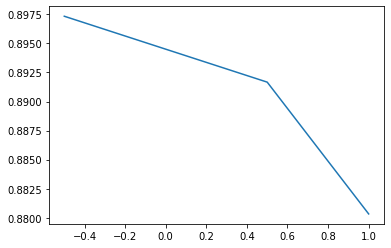

(0, 0.31622776601683794, -0.5)

In [15]:
score = np.array(score)
plt.plot(np.log10(alphas_being_tested), score)
plt.show()
best_index = np.argmax(score)
best_alpha = alphas_being_tested[best_index]
(
    best_index,
    best_alpha,
    np.log10(best_alpha),
)

# nltk

In [16]:
from corpus import Corpus
import numpy as np
import matplotlib.pyplot as plt

In [17]:
from k_eval import Naive_classifier, KNN_cosine
from helper import k_stemm, k_lemm, remove_stopwords
import time

In [18]:
models = {
    'naive bayes': Naive_classifier(corpus=None, alpha=0.5),
    'knn cosine 5': KNN_cosine(corpus=None, k=5),
}
funcs_to_test = {
    'Nothing': None,
    'stopword removal': remove_stopwords,
    'lemmatizing': k_lemm,
    'stemming': k_stemm,
}

for model_name, model in models.items():
    for func_name, func in funcs_to_test.items():
        t0 = time.time()
        print(f"starting building corpus for {model_name}, {func_name}")
        pipeline = [func] if func is not None else []
        corpus = Corpus.from_file('data/train.json', pipeline=pipeline)
        model.corpus = corpus
        model.corpus_limit = len(corpus.docs)
        model.pre_build()
        model.set_valid('data/validation.json')
        print(f"starting {model_name}, {func_name}")
        model.evaluate()
        print(f"Results: {sum(model.log)/3000}% (exact number is {sum(model.log)})")
        print("confusion matrix:\n ", model.confusion_matrix)
        print("macro averaged f1: ", model.macro_averaged_f1)
        print("precision: ", model.precision)
        print("recall: ", model.recall)
        print()
        
        t1 = time.time()
        total_time = t1 - t0
        print(f"total time: {total_time}s")
        print()

starting building corpus for naive bayes, Nothing
starting naive bayes, Nothing
Results: 0.8973333333333333% (exact number is 2692)
confusion matrix:
  [[671   9  32  31]
 [ 28 735   8   9]
 [ 28   2 625  49]
 [ 23   4  85 661]]
macro averaged f1:  0.8968416726958659
precision:  [0.90309556 0.94230769 0.88778409 0.85510996]
recall:  [0.89466667 0.98       0.83333333 0.88133333]

total time: 6.363862991333008s

starting building corpus for naive bayes, stopword removal
starting naive bayes, stopword removal
Results: 0.8993333333333333% (exact number is 2698)
confusion matrix:
  [[670   7  33  31]
 [ 26 738   9   5]
 [ 30   0 626  50]
 [ 24   5  82 664]]
macro averaged f1:  0.8988510139666934
precision:  [0.90418354 0.94858612 0.88668555 0.85677419]
recall:  [0.89333333 0.984      0.83466667 0.88533333]

total time: 16.9707510471344s

starting building corpus for naive bayes, lemmatizing
starting naive bayes, lemmatizing
Results: 0.8986666666666666% (exact number is 2696)
confusion matri

##### It is clear that for naive bayes, stopword removal and lemmatizing help while stemming hurts.
##### For naive bayes, the best action is stopword removal and the worst action is stemming
##### For knn, stopword removal hurts while stemming and lemmatizing help.
##### For knn, the best action is lemmaitzing and the worst action is stopword removal

# Testing for accuracy

In [4]:
from corpus import Corpus
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from k_eval import Naive_classifier, KNN_cosine
from helper import k_stemm, k_lemm, remove_stopwords
import time

In [12]:
models = {
    'naive bayes': Naive_classifier(corpus=None, alpha=0.3),
}
funcs_to_test = {
    'stopword removal': remove_stopwords,
    'lemmatizing': k_lemm,
    'stemming': k_stemm,
}

def kiarash():
    def convert_to_pipe(num):
        pipeline = []
        if num % 2 == 0:
            pipeline.append(remove_stopwords)
        if (num / 2) % 2 == 0:
            pipeline.append(k_lemm)
        if (num / 4) % 2 == 0:
            pipeline.append(k_stemm)
        return pipeline
    return ((num, convert_to_pipe(num)) for num in range(8))

for model_name, model in models.items():
    for func_name, pipeline in kiarash():
        t0 = time.time()
        print(f"starting building corpus for {model_name}, {func_name}")
        corpus = Corpus.from_file('data/train.json', pipeline=pipeline)
        model.corpus = corpus
        model.corpus_limit = len(corpus.docs)
        model.pre_build()
        model.set_valid('data/validation.json')
        print(f"starting {model_name}, {func_name}")
        model.evaluate()
        print(f"Results: {sum(model.log)/3000}% (exact number is {sum(model.log)})")
        t1 = time.time()
        total_time = t1 - t0
        print(f"total time: {total_time}s")
        print()

starting building corpus for naive bayes, 0
starting naive bayes, 0
Results: 0.8976666666666666% (exact number is 2693)
total time: 41.231207847595215s

starting building corpus for naive bayes, 1
starting naive bayes, 1
Results: 0.8976666666666666% (exact number is 2693)
total time: 5.336704969406128s

starting building corpus for naive bayes, 2
starting naive bayes, 2
Results: 0.9006666666666666% (exact number is 2702)
total time: 14.680576086044312s

starting building corpus for naive bayes, 3
starting naive bayes, 3
Results: 0.8976666666666666% (exact number is 2693)
total time: 4.8275182247161865s

starting building corpus for naive bayes, 4
starting naive bayes, 4
Results: 0.901% (exact number is 2703)
total time: 18.44096612930298s

starting building corpus for naive bayes, 5
starting naive bayes, 5
Results: 0.8976666666666666% (exact number is 2693)
total time: 4.6696248054504395s

starting building corpus for naive bayes, 6
starting naive bayes, 6
Results: 0.9006666666666666% 

# SVM and Random forest

### SVM

In [1]:
from corpus import Corpus
import numpy as np
import matplotlib.pyplot as plt
from svm import SVM, Forest
import time

In [2]:
corpus = Corpus.from_file('data/train.json')
corpus.build_vectors()
corpus.build_np_vecs()

In [3]:
svm = SVM(corpus)
svm.set_valid('data/validation.json')
svm.build_valid()

In [18]:
all_results = dict()
for C in [0.0001, 0.001, 0.01, 0.1]:
    t0 = time.time()
    svm.corpus_limit = 5000
    svm.parameters['C'] = C
    svm.fit_corpus()
    t1 = time.time()
    total = t1 - t0
    print(f"time: {total}")
    t0 = time.time()
    log = svm.evaluate()
    success = sum(log) / 3000
    print(f"C={C} -> success: {success:.2f}")
    all_results[C] = success
    t1 = time.time()
    total = t1 - t0
    print(total)
best_index = max(all_results, key=all_results.get)
print("best C: ", best_index)

building with {'C': 0.0001}
time: 9.916143894195557
C=0.0001 -> success: 0.88
2.076213836669922
building with {'C': 0.001}
time: 8.398204326629639
C=0.001 -> success: 0.88
1.8980259895324707
building with {'C': 0.01}
time: 8.484028100967407
C=0.01 -> success: 0.88
2.1968557834625244
building with {'C': 0.1}
time: 10.374689102172852
C=0.1 -> success: 0.87
2.2038352489471436
best C:  0.001


### random forest

In [5]:
from corpus import Corpus
import numpy as np
import matplotlib.pyplot as plt
from svm import SVM, Forest
import time

In [6]:
corpus = Corpus.from_file('data/train.json')
corpus.build_vectors()
corpus.build_np_vecs()

In [7]:
forest = Forest(corpus)
forest.set_valid('data/validation.json')
forest.build_valid()

In [8]:
all_logs = dict()
for tree_count in [50, 100, 250]:
    for max_depth in [5, 10, 25]:
        params = (tree_count, max_depth)
        t0 = time.time()
        forest.corpus_limit = 5000
        forest.parameters['tree_count'] = tree_count
        forest.parameters['max_depth'] = max_depth
        forest.fit_corpus()
        t1 = time.time()
        total = t1 - t0
        print(f"time: {total}")
        t0 = time.time()
        log = forest.evaluate()
        success = sum(log) / 3000
        print(f"count, depth={params} -> success: {success:.2f}")
        all_logs[params] = success
        t1 = time.time()
        total = t1 - t0
        print(total)

building with {'tree_count': 50, 'max_depth': 5}
time: 17.881738901138306
count, depth=(50, 5) -> success: 0.68
3.3157081604003906
building with {'tree_count': 50, 'max_depth': 10}
time: 25.568049907684326
count, depth=(50, 10) -> success: 0.72
3.665930986404419
building with {'tree_count': 50, 'max_depth': 25}
time: 47.143261194229126
count, depth=(50, 25) -> success: 0.78
3.2599852085113525
building with {'tree_count': 100, 'max_depth': 5}
time: 25.5873441696167
count, depth=(100, 5) -> success: 0.72
2.372556209564209
building with {'tree_count': 100, 'max_depth': 10}
time: 35.37496829032898
count, depth=(100, 10) -> success: 0.76
2.765584945678711
building with {'tree_count': 100, 'max_depth': 25}
time: 65.547208070755
count, depth=(100, 25) -> success: 0.80
3.4117918014526367
building with {'tree_count': 250, 'max_depth': 5}
time: 41.387529134750366
count, depth=(250, 5) -> success: 0.76
2.991424083709717
building with {'tree_count': 250, 'max_depth': 10}
time: 70.19181489944458
co

In [9]:
best_index = max(all_logs, key=all_logs.get)
print("best count, depth: ", best_index)

best count, depth:  (250, 25)
